## Assignment 4 

In this assignment we will try to improve the inversion using some commong regulization and different objective function.

In [1]:
import time
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from scipy import signal,interpolate
from torchvision.transforms import GaussianBlur 
%matplotlib inline



## Setting the parameters

In [2]:
device = torch.device('cuda:0')


# Define the model and achuisition parameters
par = {'nx':600,   'dx':0.01, 'ox':0,
       'nz':200,   'dz':0.01, 'oz':0,
       'ns':30,    'ds':0.2,   'osou':0,  'sz':0,
       'nr':300,   'dr':0.02,  'orec':0, 'rz':0,
       'nt':1500,  'dt':0.002,  'ot':0,
       'freq':10,
       'num_batches':3, # increase thus number if you have a CUDA out of memory error 
        'FWI_itr': 200
      }

# Mapping the par dictionary to variables 
for k in par:
    locals()[k] = par[k]
    
fs = 1/dt # sampling frequency


# Don't change the below two lines 
num_sources_per_shot=1
num_dims = 2 



## The acquisition set-up

 Create arrays containing the source and receiver locations
 
    x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions].
    
    x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]

In [3]:

x_s = torch.zeros(ns, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(ns).float() * ds  
x_s[:, 0, 0] = sz

x_r = torch.zeros(ns, nr, num_dims)
x_r[0, :, 1] = torch.arange(nr).float() * dr
x_r[:, :, 1] = x_r[0, :, 1].repeat(ns, 1)
x_r[:, :, 0] = rz





## Create source wavelet
    [nt, num_shots, num_sources_per_shot]

I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you can use any function to create the wavelet but it needs to be converted to tensor. 

torch.Size([1500, 30, 1])


Text(0.5, 0, 'Time (s)')

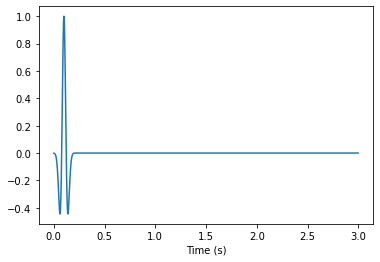

In [4]:


source_wavelet = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, ns, num_sources_per_shot))
print(source_wavelet.shape)


plt.plot(np.arange(0,nt)*dt,source_wavelet[:,0,0])
plt.xlabel('Time (s)')

### Create the velocity model 


In [5]:
vel_true = np.zeros((nz,nx))

# True velocity 
vel_true[:50,:] = 2 # 1st layer
vel_true[50:150,] = 2.5 # 2nd layer
vel_true[150:,] = 3.5 # 3rd layer
vel_true[90:130,275:325] = 2.7 # add anomaly  


# # Initial model 
vel_init = vel_true.copy()
vel_init = gaussian_filter(vel_init,sigma=30)





# Mask 
msk = np.ones_like(vel_true)
msk[:20,:] = 0 


# Convert to tensor 
vel_true = torch.Tensor(vel_true) 
vel_init = torch.Tensor(vel_init) 
msk = torch.Tensor(msk) 



# Make a copy so at the end we can see how far we came from the initial model
vel = vel_init.clone()
vel = vel.to(device)
vel.requires_grad = True


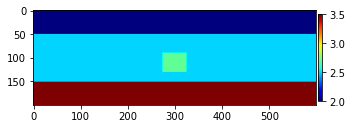

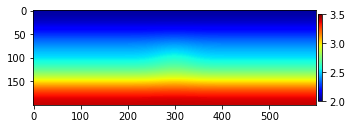

In [6]:
#plot true
plt.figure()
plt.imshow(vel_true,cmap='jet',vmin=2,vmax=3.5)
plt.colorbar(shrink=0.4,pad=0.005)

#Plot init
plt.figure()
plt.imshow(vel_init,cmap='jet',vmin=2,vmax=3.5)
plt.colorbar(shrink=0.4,pad=0.005)


## Forward modeling 

In [7]:
# Create 'true' data
prop = deepwave.scalar.Propagator({'vp': vel_true.to(device)}, dx) # create a propegator 

data_true = prop(source_wavelet.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

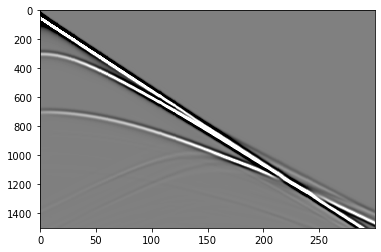

In [8]:
# Plot one shot gather
d_vmin, d_vmax = np.percentile(data_true[:,0].cpu().numpy(), [2,98])

plt.imshow(data_true[:,0,].cpu().numpy(), aspect='auto',
           vmin=-d_vmax, vmax=d_vmax,cmap='gray')



##  Set the optimizer and the criterion 


In [9]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([{'params': [vel], 'lr': 0.01}])

## Main inversion loop 

Epoch: 0 Loss:  3.454738665281676e-13


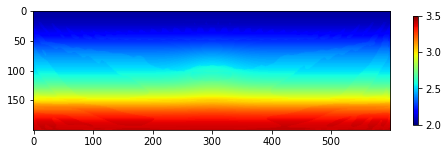

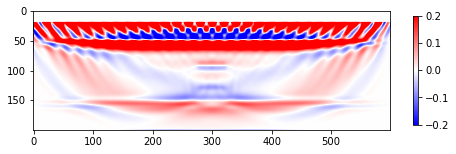

Epoch: 1 Loss:  3.397648915687279e-13
Epoch: 2 Loss:  3.344021836781258e-13
Epoch: 3 Loss:  3.293533252114039e-13
Epoch: 4 Loss:  3.247660861484085e-13
Epoch: 5 Loss:  3.2074326918388185e-13
Epoch: 6 Loss:  3.172877406773175e-13
Epoch: 7 Loss:  3.143786432894223e-13
Epoch: 8 Loss:  3.1185668739226735e-13
Epoch: 9 Loss:  3.094771075691505e-13
Epoch: 10 Loss:  3.0703427810179623e-13


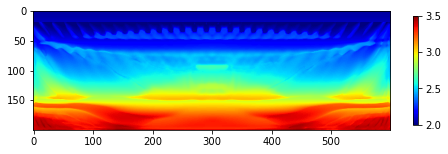

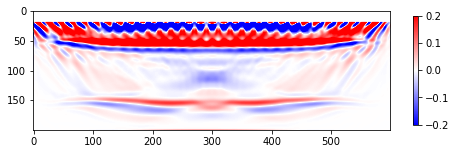

Epoch: 11 Loss:  3.044058535513032e-13
Epoch: 12 Loss:  3.0158768684436163e-13
Epoch: 13 Loss:  2.985972065308942e-13
Epoch: 14 Loss:  2.9546138213994155e-13
Epoch: 15 Loss:  2.921842929821776e-13
Epoch: 16 Loss:  2.8873092610369466e-13
Epoch: 17 Loss:  2.850286399589362e-13
Epoch: 18 Loss:  2.810225400366566e-13
Epoch: 19 Loss:  2.767166582136847e-13
Epoch: 20 Loss:  2.7210123667046823e-13


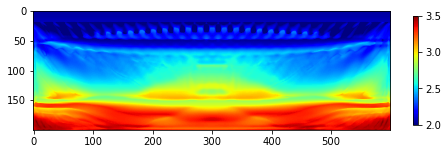

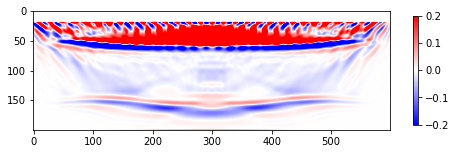

Epoch: 21 Loss:  2.6723550672694274e-13
Epoch: 22 Loss:  2.62479301531629e-13
Epoch: 23 Loss:  2.5773860042738184e-13
Epoch: 24 Loss:  2.532129711528379e-13
Epoch: 25 Loss:  2.4913706893944093e-13
Epoch: 26 Loss:  2.4574282496067634e-13
Epoch: 27 Loss:  2.4301138765127003e-13
Epoch: 28 Loss:  2.4079355046349726e-13
Epoch: 29 Loss:  2.387257668563965e-13
Epoch: 30 Loss:  2.3649384859290856e-13


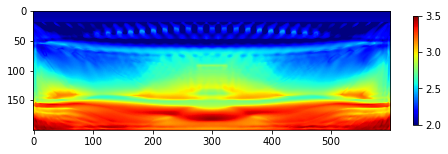

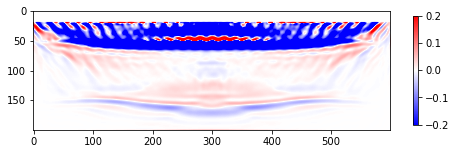

Epoch: 31 Loss:  2.339404305039608e-13
Epoch: 32 Loss:  2.3115498637383755e-13
Epoch: 33 Loss:  2.282693145291316e-13
Epoch: 34 Loss:  2.2544290110941556e-13
Epoch: 35 Loss:  2.2271775217260967e-13
Epoch: 36 Loss:  2.2004767392990246e-13
Epoch: 37 Loss:  2.1737439051452284e-13
Epoch: 38 Loss:  2.146739342821953e-13
Epoch: 39 Loss:  2.1215123299604677e-13
Epoch: 40 Loss:  2.0971311303187926e-13


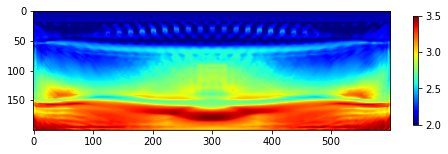

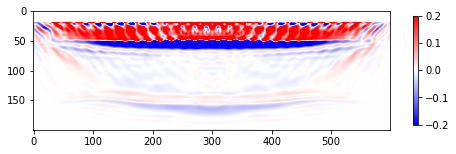

Epoch: 41 Loss:  2.073580226253334e-13
Epoch: 42 Loss:  2.051277645464221e-13
Epoch: 43 Loss:  2.0298228430113557e-13
Epoch: 44 Loss:  2.0085485602202094e-13
Epoch: 45 Loss:  1.9865503691910216e-13
Epoch: 46 Loss:  1.9636493088026966e-13
Epoch: 47 Loss:  1.9404238009142552e-13
Epoch: 48 Loss:  1.9173008178937495e-13
Epoch: 49 Loss:  1.8948225963526938e-13
Epoch: 50 Loss:  1.872486269770962e-13


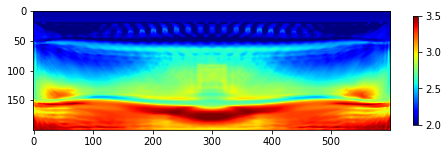

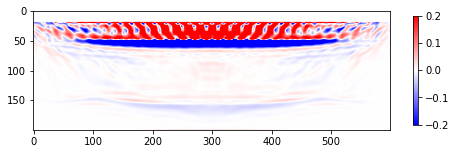

Epoch: 51 Loss:  1.849794663689834e-13
Epoch: 52 Loss:  1.826881609314976e-13
Epoch: 53 Loss:  1.8038357401739882e-13
Epoch: 54 Loss:  1.7811433209412308e-13
Epoch: 55 Loss:  1.7586967445510845e-13
Epoch: 56 Loss:  1.7361291440934346e-13
Epoch: 57 Loss:  1.7132630492251721e-13
Epoch: 58 Loss:  1.6904996825127527e-13
Epoch: 59 Loss:  1.6680459571645316e-13
Epoch: 60 Loss:  1.6461998932526707e-13


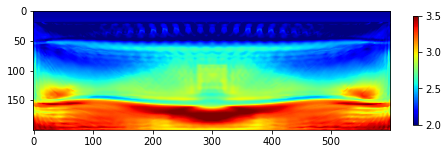

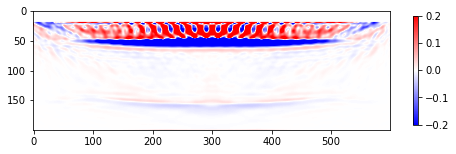

Epoch: 61 Loss:  1.6248535787796899e-13
Epoch: 62 Loss:  1.604024293217713e-13
Epoch: 63 Loss:  1.583996809043607e-13
Epoch: 64 Loss:  1.5649506294795543e-13
Epoch: 65 Loss:  1.5467144505823018e-13
Epoch: 66 Loss:  1.5291692811634193e-13
Epoch: 67 Loss:  1.5124963523923014e-13
Epoch: 68 Loss:  1.496787956978881e-13
Epoch: 69 Loss:  1.48294672711307e-13
Epoch: 70 Loss:  1.4700959498131425e-13


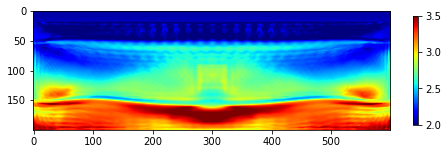

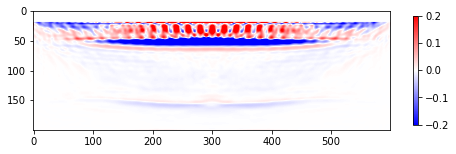

Epoch: 71 Loss:  1.458319311934287e-13
Epoch: 72 Loss:  1.44777713987276e-13
Epoch: 73 Loss:  1.4383058546257876e-13
Epoch: 74 Loss:  1.4297096560572826e-13
Epoch: 75 Loss:  1.4220974048416261e-13
Epoch: 76 Loss:  1.4153513972804677e-13
Epoch: 77 Loss:  1.4095931656610793e-13
Epoch: 78 Loss:  1.4044880980879776e-13
Epoch: 79 Loss:  1.4001792753666129e-13
Epoch: 80 Loss:  1.3964330180474965e-13


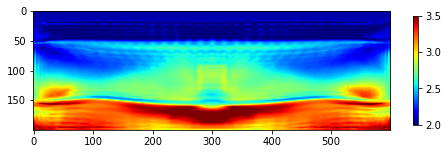

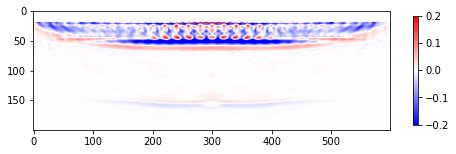

Epoch: 81 Loss:  1.3930920829343003e-13
Epoch: 82 Loss:  1.3902750885209578e-13
Epoch: 83 Loss:  1.3879102741761774e-13
Epoch: 84 Loss:  1.3856147471264825e-13
Epoch: 85 Loss:  1.3836753466091312e-13
Epoch: 86 Loss:  1.3819454681616127e-13
Epoch: 87 Loss:  1.3803446775352557e-13
Epoch: 88 Loss:  1.3790282866912688e-13
Epoch: 89 Loss:  1.3778498944550487e-13
Epoch: 90 Loss:  1.3766684190189005e-13


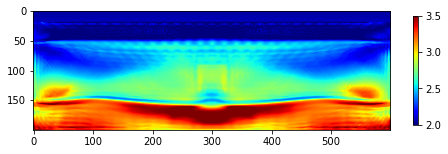

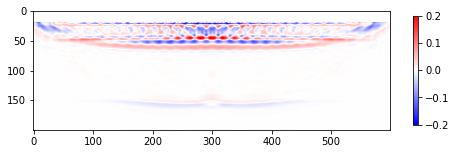

Epoch: 91 Loss:  1.3756065446349046e-13
Epoch: 92 Loss:  1.3747826865090872e-13
Epoch: 93 Loss:  1.373840006601429e-13
Epoch: 94 Loss:  1.373075542425873e-13
Epoch: 95 Loss:  1.3724265796630046e-13
Epoch: 96 Loss:  1.3716387034967865e-13
Epoch: 97 Loss:  1.3710960941907754e-13
Epoch: 98 Loss:  1.370452416913498e-13
Epoch: 99 Loss:  1.369946772125305e-13
Epoch: 100 Loss:  1.369374177852961e-13


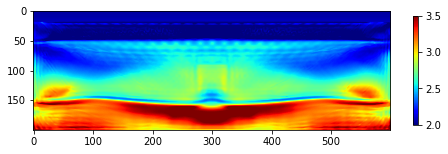

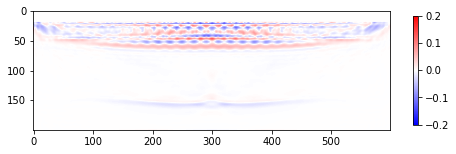

Epoch: 101 Loss:  1.3688424444499928e-13
Epoch: 102 Loss:  1.3682946513023445e-13
Epoch: 103 Loss:  1.367786668703217e-13
Epoch: 104 Loss:  1.367352953952905e-13
Epoch: 105 Loss:  1.3668524591250314e-13
Epoch: 106 Loss:  1.3664731916525688e-13
Epoch: 107 Loss:  1.366047405130643e-13
Epoch: 108 Loss:  1.3656732537371818e-13
Epoch: 109 Loss:  1.3652843639704385e-13
Epoch: 110 Loss:  1.3649868521180449e-13


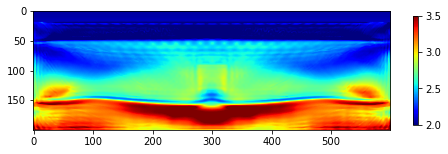

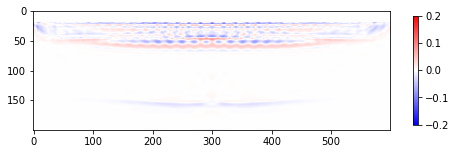

Epoch: 111 Loss:  1.3646667753079364e-13
Epoch: 112 Loss:  1.3643018735142592e-13
Epoch: 113 Loss:  1.3640294338371044e-13
Epoch: 114 Loss:  1.363779355829757e-13
Epoch: 115 Loss:  1.3634018501858247e-13
Epoch: 116 Loss:  1.3632374919127395e-13
Epoch: 117 Loss:  1.362937777774683e-13
Epoch: 118 Loss:  1.3627054196965922e-13
Epoch: 119 Loss:  1.3625129060483403e-13
Epoch: 120 Loss:  1.3622345371405546e-13


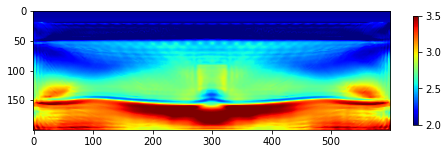

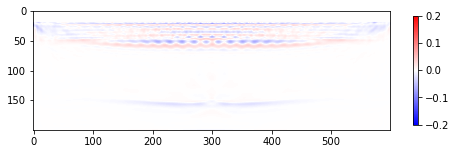

Epoch: 121 Loss:  1.3620775311134516e-13
Epoch: 122 Loss:  1.3617823909533103e-13
Epoch: 123 Loss:  1.3616283664821816e-13
Epoch: 124 Loss:  1.3614734949781056e-13
Epoch: 125 Loss:  1.3612437457614923e-13
Epoch: 126 Loss:  1.3610200951820993e-13
Epoch: 127 Loss:  1.3608620727154595e-13
Epoch: 128 Loss:  1.3607683908714932e-13
Epoch: 129 Loss:  1.3606063704093424e-13
Epoch: 130 Loss:  1.3605103168731238e-13


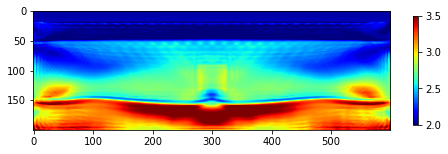

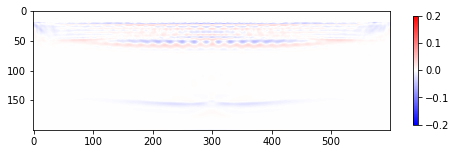

Epoch: 131 Loss:  1.3603475849032973e-13
Epoch: 132 Loss:  1.3602536658901057e-13
Epoch: 133 Loss:  1.3601154639944317e-13
Epoch: 134 Loss:  1.3600969309135458e-13
Epoch: 135 Loss:  1.3600029441377184e-13
Epoch: 136 Loss:  1.3598898144172832e-13
Epoch: 137 Loss:  1.3598564074378434e-13
Epoch: 138 Loss:  1.3598705359474036e-13
Epoch: 139 Loss:  1.3597799373033653e-13
Epoch: 140 Loss:  1.3596975040569385e-13


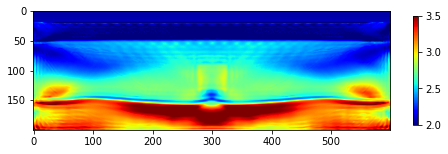

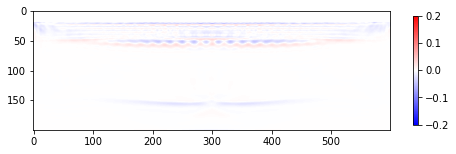

Epoch: 141 Loss:  1.359744599088806e-13
Epoch: 142 Loss:  1.3596601668446236e-13
Epoch: 143 Loss:  1.3596660283126186e-13
Epoch: 144 Loss:  1.3597150884609235e-13
Epoch: 145 Loss:  1.3596111066963186e-13
Epoch: 146 Loss:  1.359640007460479e-13
Epoch: 147 Loss:  1.3596337055353513e-13
Epoch: 148 Loss:  1.359663724383002e-13
Epoch: 149 Loss:  1.3596265226959586e-13
Epoch: 150 Loss:  1.3597516125216091e-13


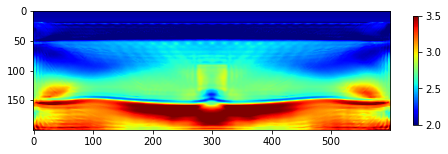

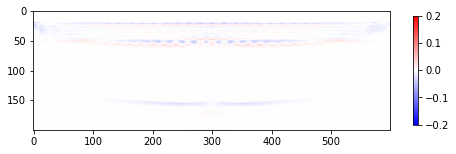

Epoch: 151 Loss:  1.3597617091543404e-13
Epoch: 152 Loss:  1.359769230806912e-13
Epoch: 153 Loss:  1.3598227632891785e-13
Epoch: 154 Loss:  1.3598094140499298e-13
Epoch: 155 Loss:  1.3598073811708564e-13
Epoch: 156 Loss:  1.3598731109275633e-13
Epoch: 157 Loss:  1.3599279308999096e-13
Epoch: 158 Loss:  1.3600223920141874e-13
Epoch: 159 Loss:  1.3600343860007205e-13
Epoch: 160 Loss:  1.3600596614638666e-13


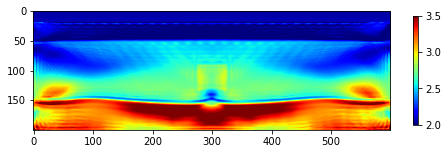

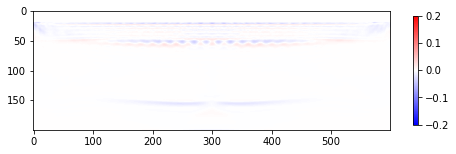

Epoch: 161 Loss:  1.3601336921434566e-13
Epoch: 162 Loss:  1.3602080616362255e-13
Epoch: 163 Loss:  1.360300151058251e-13
Epoch: 164 Loss:  1.3603818050343663e-13
Epoch: 165 Loss:  1.3603662535094548e-13
Epoch: 166 Loss:  1.360430628013446e-13
Epoch: 167 Loss:  1.3605264104991216e-13
Epoch: 168 Loss:  1.3605326446616134e-13
Epoch: 169 Loss:  1.36067931688676e-13
Epoch: 170 Loss:  1.3606303583824086e-13


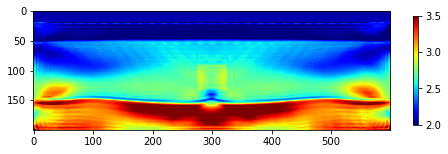

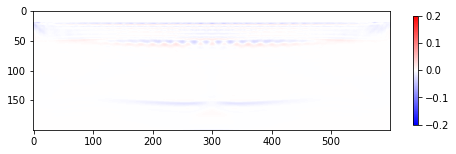

Epoch: 171 Loss:  1.360711978477206e-13
Epoch: 172 Loss:  1.3608188740351496e-13
Epoch: 173 Loss:  1.3607895328138567e-13
Epoch: 174 Loss:  1.3609700185942576e-13
Epoch: 175 Loss:  1.3609599897241621e-13
Epoch: 176 Loss:  1.360992752958562e-13
Epoch: 177 Loss:  1.361079116437864e-13
Epoch: 178 Loss:  1.3610973784682068e-13
Epoch: 179 Loss:  1.361243237541724e-13
Epoch: 180 Loss:  1.3612610591149342e-13


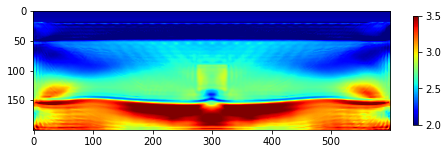

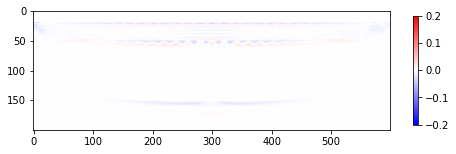

Epoch: 181 Loss:  1.3613622626114721e-13
Epoch: 182 Loss:  1.361414101027844e-13
Epoch: 183 Loss:  1.3615090364805724e-13
Epoch: 184 Loss:  1.3615429855610983e-13
Epoch: 185 Loss:  1.3616361930666142e-13


KeyboardInterrupt: 

In [10]:


# Iterative inversion loop
num_shots_per_batch = int(ns / num_batches)
epoch_loss = []
updates = []
gradients = []
msk = msk.to(device)


t_start = time.time()
for epoch in range(FWI_itr):
  running_loss=0
  optimizer.zero_grad()

    
  for it in range(num_batches):
    prop = deepwave.scalar.Propagator({'vp': vel}, dx)
    batch_src_wvl = source_wavelet[:,it::num_batches,].to(device)
    batch_data_true = data_true[:,it::num_batches].to(device)
    batch_x_s = x_s[it::num_batches].to(device)
    batch_x_r = x_r[it::num_batches].to(device)
    data_pred = prop(batch_src_wvl, batch_x_s, batch_x_r, dt)
    loss = criterion(data_pred, batch_data_true)
    running_loss += loss.item()
    loss.backward()


  epoch_loss.append(running_loss)     

  # Apply some operations to the gradient
  if epoch==0: gmax = (torch.abs(vel.grad)*msk).max()
  vel.grad = vel.grad /gmax *msk   # normalizing by the first gradient and mask the wter layer

    
  # update the vel 
  optimizer.step()
  print('Epoch:', epoch, 'Loss: ', running_loss)

    
  # save the vel updates and gradients for each iteration
  updates.append(vel.detach().clone().cpu().numpy())
  gradients.append(vel.grad.cpu().detach().numpy())  
    
  # plotting every 10 itr   
  if epoch % 10 == 0:
    plt.figure(figsize=(8, 4))
    plt.imshow(vel.cpu().detach().numpy(), vmin=2, vmax=3.5,
               cmap='jet')
    plt.colorbar(shrink=0.5)
    plt.show()   

    plt.figure(figsize=(8, 4))
    gr = vel.grad.cpu().detach().numpy()
    g_min, g_max = np.percentile(gr, [2,98]) 
    plt.imshow(gr, cmap='bwr',vmin=-0.2,vmax=0.2)
    plt.colorbar(shrink=0.5)
    plt.show()
    
t_end = time.time()
print('Runtime:', (t_end - t_start)/60 ,'minutes')

In [ ]:
updates = np.array(updates)
gradients = np.array(gradients)
obj = np.array(epoch_loss)

In [ ]:
plt.figure()
plt.plot(obj)


plt.figure(figsize=(8, 4))
plt.imshow(vel.cpu().detach().numpy(), vmin=2, vmax=3.5,
               cmap='jet')
plt.colorbar(shrink=0.5)
plt.show()   


In [ ]:

fig, ax = plt.subplots(1,1,figsize=(2,5))
ax.plot(vel.detach().cpu()[:,300],np.arange(0,200),linewidth=2,color='red' )
ax.plot(vel_true.detach().cpu()[:,300],np.arange(0,200),linewidth=2,color='black' )
ax.axis('tight')
ax.invert_yaxis()